# RNA correlated loop

In [1]:
import numpy as np
import pandas as pd
import cooler
import anndata
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/diff/neu/'
outdir = '/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/'

In [4]:
# no L5ET
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       # 'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]

In [5]:
loopq = pd.read_hdf(f'{indir}loop_Q.hdf')
loopall = pd.read_hdf(f'{indir}merged_loop.hdf')

In [6]:
expr = pd.read_hdf(f'{outdir}cluster_expr.hdf').loc[leg]


In [7]:
from scipy.stats import rankdata

deg = np.zeros(expr.shape[1])
for i in range(len(leg)-1):
    for j in range(i+1, len(leg)):
        tmp = np.load(f'{outdir}DEG/{leg[i]}-{leg[j]}.npz')
        # deg[np.logical_and(np.abs(tmp['fc'])>1, tmp['fdr']<1e-3)] = 1
        rank = rankdata(tmp['fdr'])
        deg[rank<=100] = 1

print(deg.sum())


1131.0


In [8]:
chrom_size_path = f'/data/hba/loop_majortype/hg38_with_chrl.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)


In [9]:
gene_meta = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/gencode.v33.bed', sep='\t', index_col=None, header=None)
gene_meta.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand']
gene_meta = gene_meta.set_index('gene_id').loc[expr.columns[deg==1]]
gene_meta = gene_meta.loc[gene_meta['chrom'].isin(chrom_sizes.index[:22])]
gene_meta

chrom     start       end   gene_name strand
gene                                                            
ENSG00000002746.15   chr7  43112629  43566001       HECW1      +
ENSG00000005108.16   chr7  11370365  11832198      THSD7A      -
ENSG00000006128.12   chr7  97732084  97740472        TAC1      +
ENSG00000006468.14   chr7  13891229  13991425        ETV1      -
ENSG00000007237.18  chr17   9910609  10198551  AC005747.1      -
...                   ...       ...       ...         ...    ...
ENSG00000286954.1    chr6  22663507  22675493  AL033539.2      +
ENSG00000287172.1    chr2  76185020  76399490  AC073091.3      +
ENSG00000287694.1   chr16  76277288  76819624  AC106741.2      +
ENSG00000287722.1   chr13  53207831  53801489  AL356295.1      +
ENSG00000287912.1   chr11  81175201  81431520  AP003464.1      +

[1099 rows x 5 columns]

In [10]:
import cooler
# from qnorm import quantile_normalize
from scipy.stats import norm
from tqdm import tqdm
from ALLCools.mcds.correlation import corr_array


In [11]:
def shuffle_corr_norm(rna_data, dmr_data):
    
    shuffle_rna_data = rna_data.copy()
    for col, data in shuffle_rna_data.items():
        n_gene = shuffle_rna_data.shape[0]
        shuffle_rna_data[col] = shuffle_rna_data[col].sample(n_gene).values
    
    if dmr_data.shape[0] > 50000:
        shuffle_dmr_data = dmr_data.sample(50000).copy()
    else:
        shuffle_dmr_data = dmr_data.copy()
    for col, data in shuffle_dmr_data.items():
        n_dmr = shuffle_dmr_data.shape[0]
        shuffle_dmr_data[col] = shuffle_dmr_data[col].sample(n_dmr).values

    # shuffle corr
    shuffle_corr = corr_array(shuffle_rna_data, shuffle_dmr_data)
    mu, std = norm.fit(shuffle_corr.ravel())
    return mu, std, shuffle_corr.ravel()


In [12]:
null_mu, null_std, shuffle_corr = shuffle_corr_norm(expr.loc[:,  gene_meta.index].T, loopq)
null_mu, null_std


(0.0026065808764122516, 0.2236524692590272)

In [13]:
shuffle_corr.shape

(54950000,)

In [14]:
gene_slop = 5000000

In [15]:
gene_records = []
for gene, row in tqdm(gene_meta.iterrows(), total=gene_meta.shape[0]):
    gene_rna = expr[[gene]].T
    
    dmr_chrom = row['chrom']
    dmr_start = row['start'] - gene_slop
    dmr_end = row['end'] + gene_slop
    sel_dmr = (loopall[0]==dmr_chrom) & (loopall[1] > dmr_start) & (loopall[5] < dmr_end)
    gene_dmr = loopq.loc[sel_dmr]

    gene_corr = corr_array(gene_rna, gene_dmr).ravel()
    gene_corr = pd.Series(gene_corr, index=gene_dmr.index)

    # pvalue = norm.sf(gene_corr.values, null_mu, null_std)
    # pvalue[pvalue > 0.5] = 1 - pvalue[pvalue > 0.5]
    # pvalue *= 2  # two tailed
    # perform multi-test correction and  q-value
    # _, q, *_ = fdrcorrection(pvalue)

    gene_corr.name = 'corr'
    gene_corr = gene_corr.reset_index()
    gene_corr['gene'] = gene
    # gene_corr["q"] = q
    
    # minimum filter
    # gene_corr = gene_corr[
    #     (gene_corr["q"] < min_q) & (gene_corr["corr"].abs() > min_corr)
    # ].set_index("dmr")

    # gene_records[gene] = gene_corr
    gene_records.append(gene_corr)
    

100%|██████████| 1099/1099 [02:42<00:00,  6.77it/s]


In [16]:
gene_records = pd.concat(gene_records, axis=0)
gene_records.index = np.arange(gene_records.shape[0])
gene_records

index      corr                gene
0         1363388  0.551680  ENSG00000002746.15
1         1363389  0.613300  ENSG00000002746.15
2         1363390  0.616141  ENSG00000002746.15
3         1363391  0.591706  ENSG00000002746.15
4         1363392  0.579583  ENSG00000002746.15
...           ...       ...                 ...
11707151  1999960  0.015354   ENSG00000287912.1
11707152  1999961  0.013737   ENSG00000287912.1
11707153  1999991  0.096387   ENSG00000287912.1
11707154  1999992  0.076112   ENSG00000287912.1
11707155  2000026  0.026490   ENSG00000287912.1

[11707156 rows x 3 columns]

<AxesSubplot:ylabel='Density'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


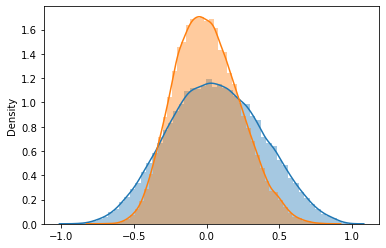

In [17]:
fig, ax = plt.subplots()
sns.distplot(np.random.choice(gene_records['corr'], 50000), ax=ax)
sns.distplot(np.random.choice(shuffle_corr, 50000), ax=ax)

In [18]:
t1 = rankdata(np.concatenate((gene_records['corr'].values, shuffle_corr)))[:gene_records.shape[0]]
t2 = rankdata(gene_records['corr'].values)


In [19]:
gene_records['FDRneg'] = (t1 - t2) / len(shuffle_corr) / t2 * gene_records.shape[0]
gene_records['FDRpos'] = (len(shuffle_corr) - t1 + t2) / len(shuffle_corr) / (gene_records.shape[0] - t2) * gene_records.shape[0]


In [20]:
gene_meta[['TSS', 'TES']] = gene_meta[['start', 'end']]
selg = (gene_meta['strand']=='-')
gene_meta.loc[selg, ['TSS', 'TES']] = gene_meta.loc[selg, ['TES', 'TSS']].values


In [21]:
loopall['start'] = loopall[[1, 2]].mean(axis=1)
loopall['end'] = loopall[[4, 5]].mean(axis=1)

In [22]:
gene_records['TSSdist1'] = loopall.loc[gene_records['index'], 'start'].values - gene_meta.loc[gene_records['gene'], 'TSS'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TSSdist1'] = -gene_records.loc[selg.values, 'TSSdist1'].values

gene_records['TESdist1'] = loopall.loc[gene_records['index'], 'start'].values - gene_meta.loc[gene_records['gene'], 'TES'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TESdist1'] = -gene_records.loc[selg.values, 'TESdist1'].values


In [23]:
gene_records['TSSdist2'] = loopall.loc[gene_records['index'], 'end'].values - gene_meta.loc[gene_records['gene'], 'TSS'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TSSdist2'] = -gene_records.loc[selg.values, 'TSSdist2'].values

gene_records['TESdist2'] = loopall.loc[gene_records['index'], 'end'].values - gene_meta.loc[gene_records['gene'], 'TES'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TESdist2'] = -gene_records.loc[selg.values, 'TESdist2'].values


In [24]:
gene_records.to_hdf(f'{outdir}DEG_neu_loop_5M_corr.hdf', key='data')

In [25]:
gene_records = pd.read_hdf(f'{outdir}DEG_neu_loop_5M_corr.hdf')

In [26]:
gene_records = gene_records[~gene_records['gene'].isin(gene_meta.index[gene_meta['chrom'].isin(['chrX', 'chrY'])])]


In [27]:
dist = 2000000

In [28]:
gene_records['coord1'] = 0
selp = (gene_records['TSSdist1']<=0)
gene_records.loc[selp, 'coord1'] = gene_records.loc[selp, 'TSSdist1'] / (dist/200) - 100

selp = (gene_records['TESdist1']>=0)
gene_records.loc[selp, 'coord1'] = gene_records.loc[selp, 'TESdist1'] / (dist/200) + 100

selp = (gene_records['TESdist1']<0) & (gene_records['TSSdist1']>0)
gene_records.loc[selp, 'coord1'] = gene_records.loc[selp, 'TSSdist1'] / (gene_records.loc[selp, 'TSSdist1'] - gene_records.loc[selp, 'TESdist1']) * 200 - 100


In [29]:
gene_records['coord2'] = 0
selp = (gene_records['TSSdist2']<=0)
gene_records.loc[selp, 'coord2'] = gene_records.loc[selp, 'TSSdist2'] / (dist/200) - 100

selp = (gene_records['TESdist2']>=0)
gene_records.loc[selp, 'coord2'] = gene_records.loc[selp, 'TESdist2'] / (dist/200) + 100

selp = (gene_records['TESdist2']<0) & (gene_records['TSSdist2']>0)
gene_records.loc[selp, 'coord2'] = gene_records.loc[selp, 'TSSdist2'] / (gene_records.loc[selp, 'TSSdist2'] - gene_records.loc[selp, 'TESdist2']) * 200 - 100


In [30]:
gene_records = gene_records.loc[(gene_records[['coord1','coord2']].min(axis=1)>-300) & (gene_records[['coord1','coord2']].max(axis=1)<300)]

In [31]:
gene_records['group1'], group1 = pd.cut(gene_records['coord1'], 300, labels=False, retbins=True)
gene_records['group2'], group2 = pd.cut(gene_records['coord2'], 300, labels=False, retbins=True)


In [32]:
threspos = gene_records.loc[gene_records['FDRpos']<0.1, 'corr'].min()
thresneg = gene_records.loc[gene_records['FDRneg']<0.1, 'corr'].max()
print(threspos, thresneg)


0.6027898776172802 -0.5201701393194751


In [33]:
thres = np.max(np.abs([thresneg, threspos]))
res = 10000

In [34]:
## promoter
tmp = gene_records.loc[(gene_records['corr']>thres) & (((gene_records['TSSdist1']>-res) & (gene_records['TSSdist1']<res)) | ((gene_records['TSSdist2']>-res) & (gene_records['TSSdist2']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_loopposcorr_tss.csv.gz', tmp, delimiter='\n', fmt='%s')

tmp = gene_records.loc[(gene_records['corr']>thres) & (((gene_records['TESdist1']>-res) & (gene_records['TESdist1']<res)) | ((gene_records['TESdist2']>-res) & (gene_records['TESdist2']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_loopposcorr_tes.csv.gz', tmp, delimiter='\n', fmt='%s')


962 0.8761384335154827
877 0.7987249544626593


In [35]:
tmp = gene_records.loc[(gene_records['corr']>thres) & (((gene_records['TSSdist1']>-res) & (gene_records['TESdist1']<res)) & ((gene_records['TSSdist2']>-res) & (gene_records['TESdist2']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_loopposcorr_genebodyboth.csv.gz', tmp, delimiter='\n', fmt='%s')

tmp = gene_records.loc[(gene_records['corr']<-thres) & (((gene_records['TSSdist1']>-res) & (gene_records['TESdist1']<res)) & ((gene_records['TSSdist2']>-res) & (gene_records['TESdist2']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])

tmp = gene_records.loc[(gene_records['corr']>thres) & (((gene_records['TSSdist1']>-res) & (gene_records['TESdist1']<res)) | ((gene_records['TSSdist2']>-res) & (gene_records['TESdist2']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_loopposcorr_genebodyone.csv.gz', tmp, delimiter='\n', fmt='%s')


898 0.8178506375227687
44 0.04007285974499089
1070 0.9744990892531876


In [36]:
tmp = gene_records.loc[(gene_records['corr']>threspos) | (gene_records['corr']<thresneg)].groupby(['group1','group2'])['corr'].mean()
groupsigcorr = np.zeros((300, 300)) / 0
groupsigcorr[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


In [37]:
tmp = gene_records.groupby(['group1','group2'])['corr'].mean()
groupcorr = np.zeros((300, 300)) / 0
groupcorr[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


In [38]:
tmp = gene_records.loc[gene_records['corr']>threspos].groupby(['group1','group2'])['corr'].count()
groupposcount = np.zeros((300, 300))
groupposcount[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


In [39]:
tmp = gene_records.loc[gene_records['corr']<thresneg].groupby(['group1','group2'])['corr'].count()
groupnegcount = np.zeros((300, 300))
groupnegcount[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


In [40]:
tmp = gene_records.loc[(gene_records['corr']>threspos) | (gene_records['corr']<thresneg)].groupby(['group1','group2'])['corr'].count()
groupsigcount = np.zeros((300, 300))
groupsigcount[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


In [41]:
tmp = gene_records.groupby(['group1','group2'])['corr'].count()
groupcount = np.zeros((300, 300))
groupcount[(tmp.index.get_level_values('group1'), tmp.index.get_level_values('group2'))] = tmp.values


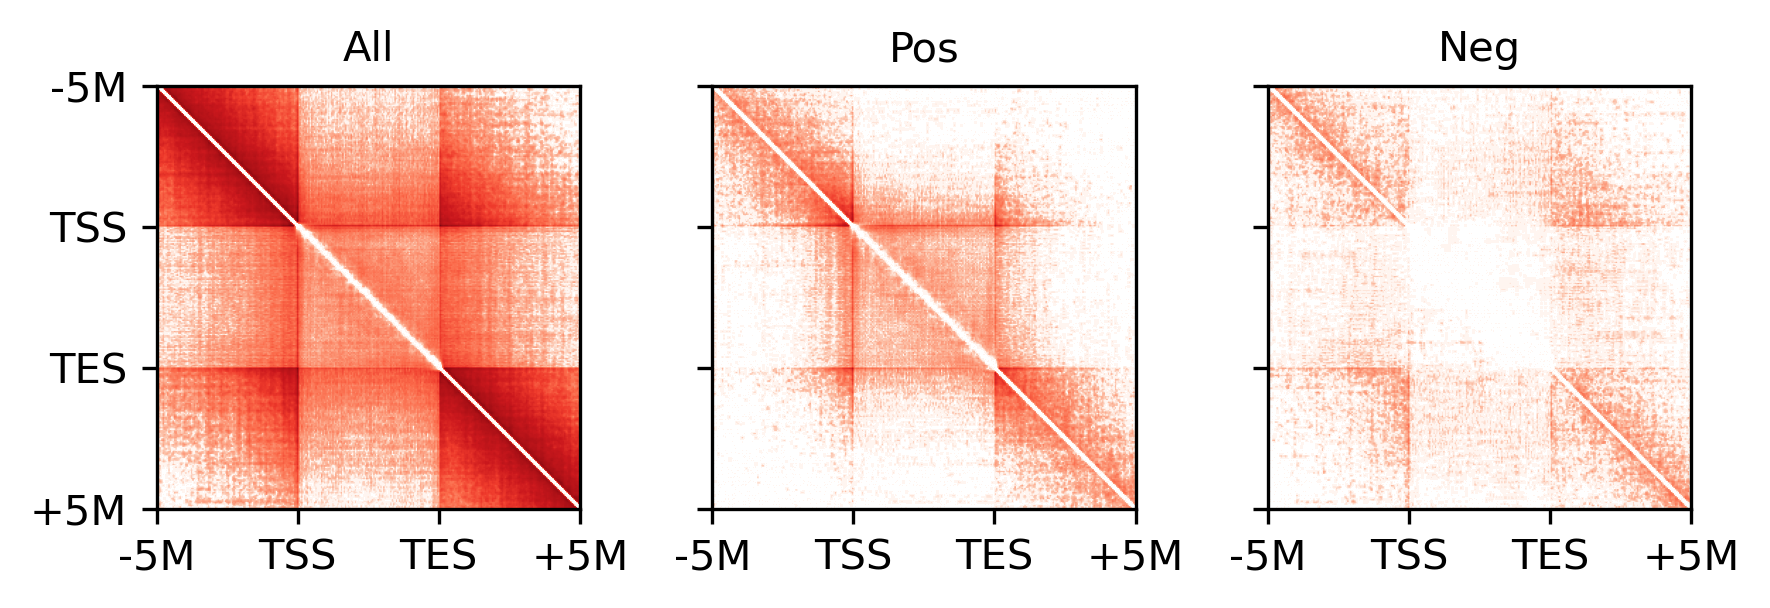

In [42]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 3, figsize=(6,2), sharex='all', sharey='all', dpi=300)
# ax = axes[0]
# plot = ax.imshow(groupcorr, vmin=-1, vmax=1, cmap=cmap)
# fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
for i,xx in enumerate([groupcount, groupposcount, groupnegcount]):
    ax = axes[i]
    plot = ax.imshow(xx, cmap='Reds', norm=LogNorm(vmin=1, vmax=1e3))
    ax.set_title(['All', 'Pos', 'Neg'][i], fontsize=10)
    
ax.set_xticks(np.arange(-0.5, 300.5, 100))
ax.set_yticks(np.arange(-0.5, 300.5, 100))
ax.set_xticklabels(['-5M', 'TSS', 'TES', '+5M'])
ax.set_yticklabels(['-5M', 'TSS', 'TES', '+5M'])

# ax.set_xlabel('Zscore log Q anova')
plt.tight_layout()



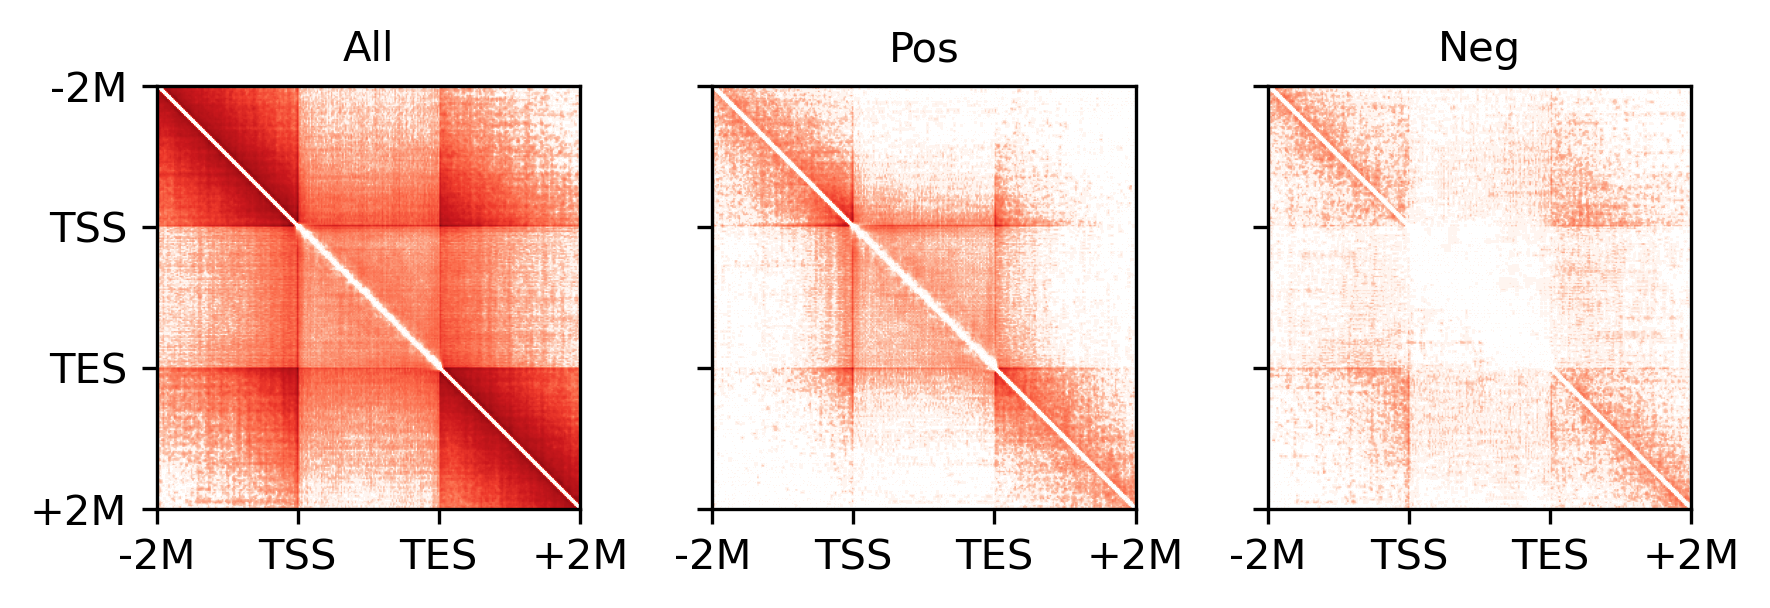

In [43]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 3, figsize=(6,2), sharex='all', sharey='all', dpi=300)
# ax = axes[0]
# plot = ax.imshow(groupcorr, vmin=-1, vmax=1, cmap=cmap)
# fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
for i,xx in enumerate([groupcount, groupposcount, groupnegcount]):
    ax = axes[i]
    plot = ax.imshow(xx, cmap='Reds', norm=LogNorm(vmin=1, vmax=1e3))
    ax.set_title(['All', 'Pos', 'Neg'][i], fontsize=10)
    
ax.set_xticks(np.arange(-0.5, 300.5, 100))
ax.set_yticks(np.arange(-0.5, 300.5, 100))
ax.set_xticklabels(['-2M', 'TSS', 'TES', '+2M'])
ax.set_yticklabels(['-2M', 'TSS', 'TES', '+2M'])

# ax.set_xlabel('Zscore log Q anova')
plt.tight_layout()
# plt.savefig('DEG_loop_sigcorr_count.pdf', transparent=True)


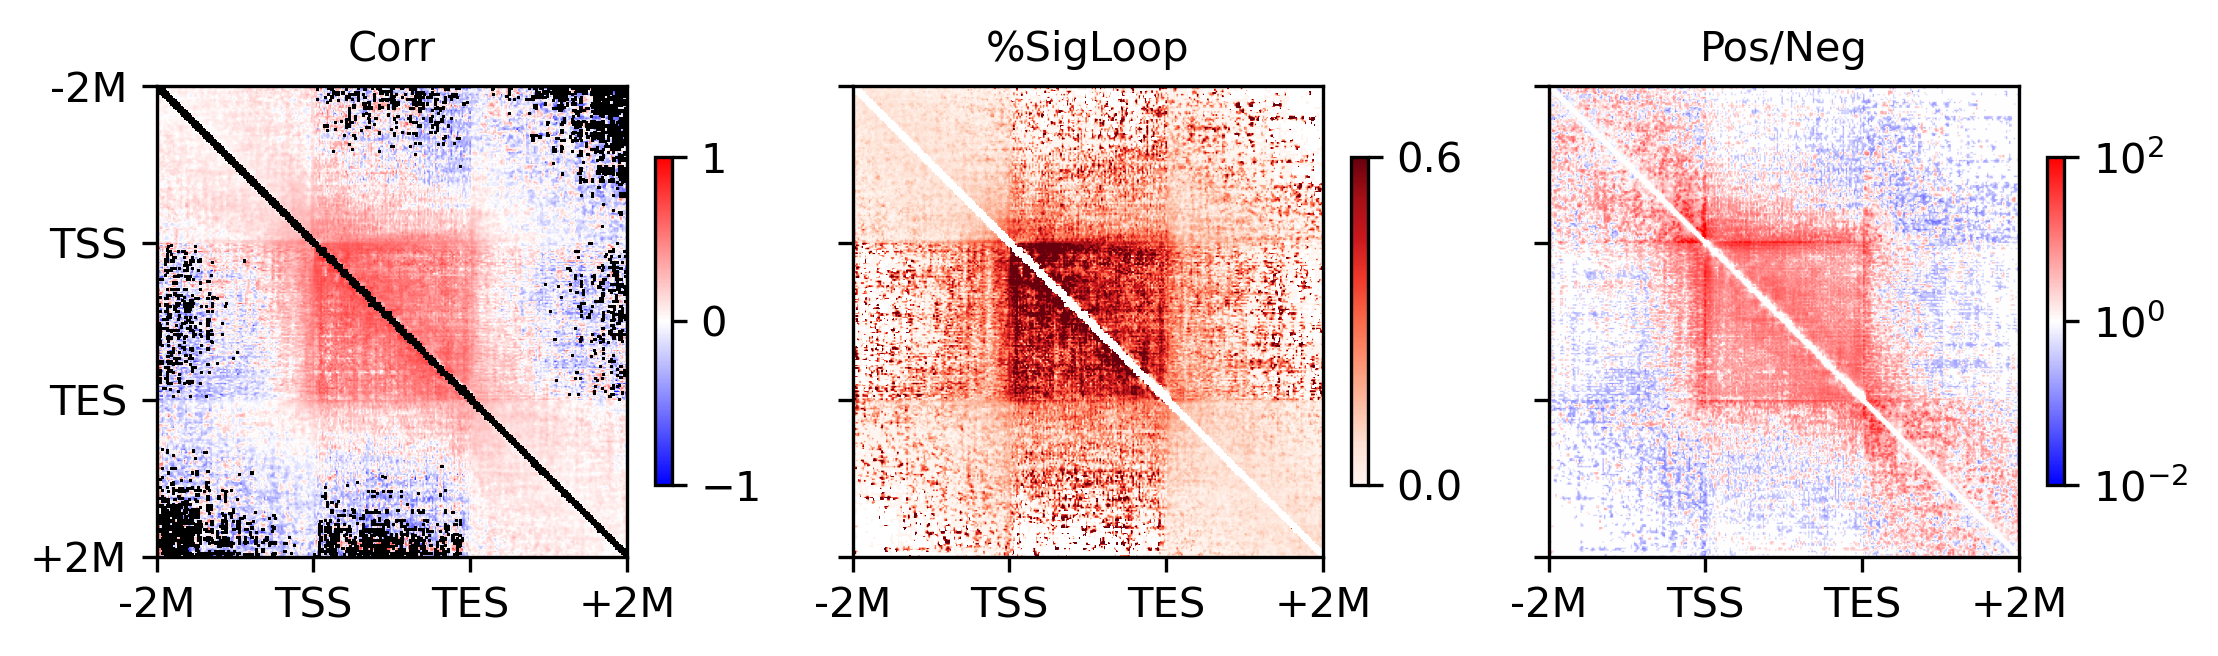

In [44]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 3, figsize=(7.5,2.5), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcorr, vmin=-1, vmax=1, cmap=cmap)
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)

ax = axes[1]
# plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1, vmax=1e3))
plot = ax.imshow(groupsigcount / groupcount, cmap='Reds', vmin=0, vmax=0.6)
fig.colorbar(plot, ax=ax, ticks=[0, 0.6], shrink=0.5, fraction=0.1)

ax = axes[2]
plot = ax.imshow((groupposcount+1) / (groupnegcount+1), cmap='bwr', norm=LogNorm(vmin=1e-2, vmax=1e2))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)

ax.set_xticks(np.arange(-0.5, 300.5, 100))
ax.set_yticks(np.arange(-0.5, 300.5, 100))
ax.set_xticklabels(['-2M', 'TSS', 'TES', '+2M'])
ax.set_yticklabels(['-2M', 'TSS', 'TES', '+2M'])

for ax,xx in zip(axes, ['Corr', '%SigLoop', 'Pos/Neg']):
    ax.set_title(xx, fontsize=10)
    
# ax.set_xlabel('Zscore log Q anova')
plt.tight_layout()
# plt.savefig('DEG_loop_sigcorr_mean.pdf', transparent=True)



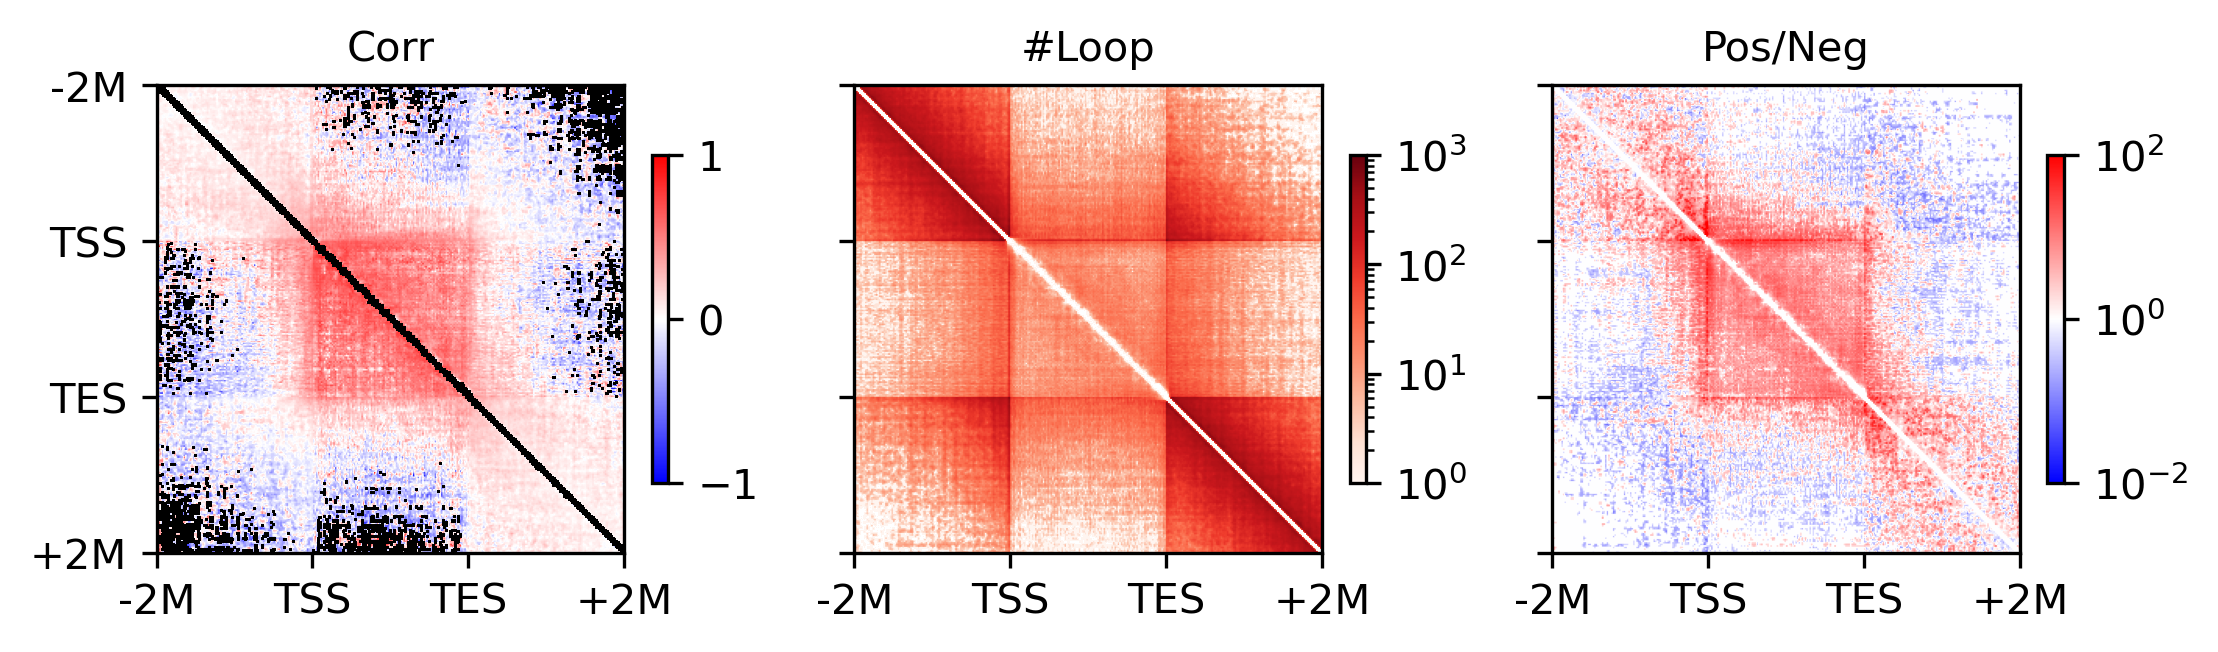

In [45]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 3, figsize=(7.5,2.5), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcorr, vmin=-1, vmax=1, cmap=cmap)
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)

ax = axes[1]
plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1, vmax=1e3))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)

ax = axes[2]
plot = ax.imshow((groupposcount+1) / (groupnegcount+1), cmap='bwr', norm=LogNorm(vmin=1e-2, vmax=1e2))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)

ax.set_xticks(np.arange(-0.5, 300.5, 100))
ax.set_yticks(np.arange(-0.5, 300.5, 100))
ax.set_xticklabels(['-2M', 'TSS', 'TES', '+2M'])
ax.set_yticklabels(['-2M', 'TSS', 'TES', '+2M'])

for ax,xx in zip(axes, ['Corr', '#Loop', 'Pos/Neg']):
    ax.set_title(xx, fontsize=10)
    
# ax.set_xlabel('Zscore log Q anova')
plt.tight_layout()
# plt.savefig('DEG_loop_sigcorr_mean.pdf', transparent=True)



In [46]:
for i in range(3):
    for j in range(i,3):
        print(groupposcount[(i*100):(i*100+100), (j*100):(j*100+100)].sum() / 
              (groupposcount[(i*100):(i*100+100), (j*100):(j*100+100)].sum() + 
               groupnegcount[(i*100):(i*100+100), (j*100):(j*100+100)].sum()))


0.7383856476742864
0.7817007006734098
0.4595160929816719
0.9778063774148058
0.6653371514283767
0.7132464224170225


In [48]:
for i in range(3):
    for j in range(i,3):
        print(groupsigcount[(i*100):(i*100+100), (j*100):(j*100+100)].sum() / groupcount[(i*100):(i*100+100), (j*100):(j*100+100)].sum())


0.08403407522975455
0.2336316443198828
0.12759025106675745
0.4697464723512085
0.1907666694847466
0.07912202825558069
